### Import dependencies

In [1]:
import pandas as pd
import numpy as np

### Read csv containing the data and image routes

In [2]:
driving_log = pd.read_csv('data/driving_log.csv')

In [3]:
driving_log.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [4]:
print(f"Number of samples: {len(driving_log)}")

Number of samples: 8036


#### Augment the data with left and right images

In [5]:
correction = 0.15

driving_log['steering_left'] = driving_log['steering'] + correction
driving_log['steering_right'] = driving_log['steering'] - correction

#### Create generator

In [6]:
df = pd.DataFrame(pd.concat([pd.concat([driving_log['center'].str.strip(),
                         driving_log['left'].str.strip(),
                         driving_log['right'].str.strip()], ignore_index=True),
              pd.concat([driving_log['steering'],
                         driving_log['steering_left'],
                         driving_log['steering_right']], ignore_index=True)
             ], axis=1, keys=['img_path', 'steering']))

In [7]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [8]:
data_generator = ImageDataGenerator(horizontal_flip=True,
                                    rotation_range=45,
                                    validation_split=0.2)\
    .flow_from_dataframe(df, directory='data',
                         x_col='img_path', y_col='steering',
                         target_size=(160, 320),
                         color_mode='rgb',
                         class_mode='raw',
                         batch_size=128,
                         shuffle=True)

Found 24108 validated image filenames.


### Define the convolutional model

In [9]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, Cropping2D
from keras.layers.pooling import MaxPooling2D

In [10]:
model = Sequential()

# Crop undesired parts of the image
model.add(Cropping2D(cropping=((50, 20), (0, 0)), input_shape=(160, 320, 3)))
# Normalize the images
model.add(Lambda(lambda x: x / 255.0 - 0.5))

model.add(Conv2D(24, 5, strides=(2, 2), activation='relu'))
model.add(Conv2D(36, 5, strides=(2, 2), activation='relu'))
model.add(Conv2D(48, 5, strides=(2, 2), activation='relu'))
model.add(Conv2D(64, 1, activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))

model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [11]:
model.compile(loss='mse', optimizer='adam')

In [12]:
history = model.fit_generator(generator=data_generator, epochs=1, verbose = 1)


Epoch 1/1
189/189 [==============================] - 460s 2s/step - loss: 0.0324


KeyError: 'val_loss'

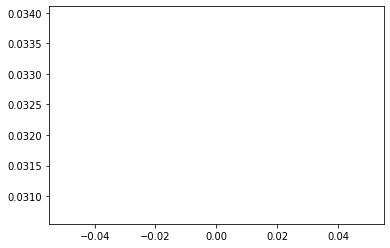

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [15]:
model.save('model.h5')